In [84]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.special import binom
from itertools import product

import qiskit
from qiskit import QuantumRegister, ClassicalRegister, transpile
from qiskit.circuit import QuantumCircuit, ParameterVector
from qiskit_aer import AerSimulator
from qiskit.quantum_info import Pauli, SparsePauliOp, Statevector
from qiskit_ibm_runtime import EstimatorV2, QiskitRuntimeService, SamplerV2

import pickle
from functools import reduce

import matplotlib.pyplot as plt

import time
import os

In [203]:
def create_circuit(n_step, n_depth, n_bath):
    n_wires = 2 + n_bath
    n_param = 2 * n_depth * n_step

    # circuit parameter storages
    param_data0 = ParameterVector('data_0', length=n_param)
    param_data1 = ParameterVector('data_1', length=n_param)
    param_bath = [ParameterVector(
        'bath_' + str(b), length=n_param) for b in range(n_bath)]

    q = QuantumRegister(n_wires, 'q')
    circuit = QuantumCircuit(q)

    for t in range(n_step):
        for d in range(n_depth):
            param_id = 2 * d + 2 * n_depth * t
            circuit.ry(param_data0[param_id], 0)
            circuit.rz(param_data0[param_id + 1], 0)
            circuit.ry(param_data1[param_id], 1)
            circuit.rz(param_data1[param_id + 1], 1)

            for b in range(n_bath):
                circuit.ry(param_bath[b][param_id], 2 + b)
                circuit.rz(param_bath[b][param_id + 1], 2 + b)

            circuit.cx(0, 1)

            for b in range(n_bath - 1):
                circuit.cx(2 + b, 2 + b + 1)

            circuit.cx(1, 2)

        if t < n_step - 1:
            for b in range(n_bath):
                circuit.reset(2 + b)

    return circuit

In [24]:
def FP1evo(dA, dB, ts):
    r = (dA**2 - 1)*dB/(dA**2 * dB**2 - 1)
    c = dA*(dB + 1) + (dA - 1)*(dA * dB - 1)*r**ts
    return c/(dA**2 * dB + 1)

## $2+2$ Qubits, HEA circuit

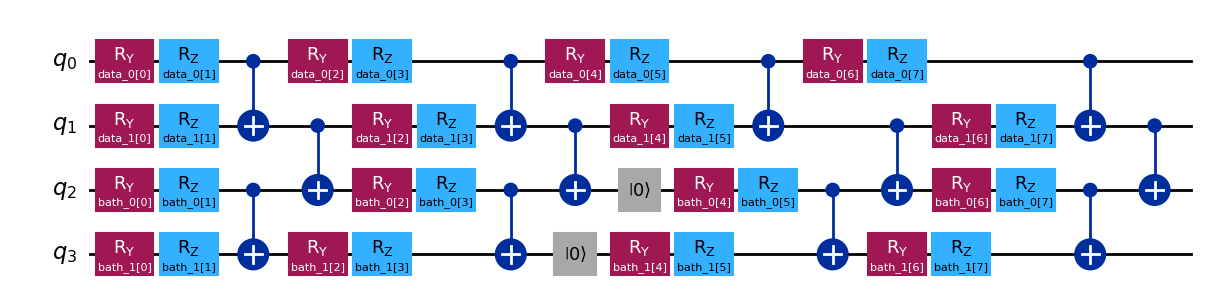

In [4]:
# plot a simple circuit
circuit = create_circuit(2, 2, 2)
circuit.draw('mpl')

In [3]:
# setup backend and estimator
# backend = FakeSherbrooke()
# backend = AerProvider().get_backend()
backend = AerSimulator()
estimator = EstimatorV2(mode=backend)

In [4]:
n_qubit = 4
pauli_op = ["I", "X", "Y", "Z"]
observables = [[Pauli('II' + q + p)] for p in pauli_op for q in pauli_op][1:]
# observables = [[SparsePauliOp.from_sparse_list([(q + p, [0, 1], 1.)], num_qubits=n_qubit)] for p in pauli_op for q in pauli_op][1:]

In [7]:
# simple test run
n_batch = 10
n_step = 1
n_depth = 4
n_bath = 2

n_total_param = (2 + n_bath) * (2 * n_depth * n_step)
param_random = np.random.uniform(0, 4. * np.pi, (n_batch, n_total_param))

circuit = create_circuit(n_step, n_depth, n_bath)

pub = (circuit, observables, param_random)
job = estimator.run([pub])
r_vals = job.result()[0].data.evs
purity = (1. + (r_vals ** 2.).sum(0)) / 4.

purity.mean()

np.float64(0.5015050828456878)

In [21]:
# noise-free simulation
n_batch = 10
n_depth = 5
n_bath = 2

steps = 8

purities = []
for n_step in range(1, 9):
    t0 = time.time()
    np.random.seed(12)
    n_total_param = (2 + n_bath) * (2 * n_depth * n_step)
    param_random = np.random.uniform(0, 4. * np.pi, (n_batch, n_total_param))
    
    circuit = create_circuit(n_step, n_depth, n_bath)
    
    pub = (circuit, observables, param_random)
    job = estimator.run([pub])
    r_vals = job.result()[0].data.evs
    purity = (1. + (r_vals ** 2.).sum(0)) / 4.

    purities.append(purity)
    print(f'step {n_step}, time={time.time() - t0:.3f}')

purities = np.array(purities)
np.save(f'data/experiment/purity/ideal/purity_Nb{n_bath}L{n_depth}.npy', purities)

step 1, time=2.924
step 2, time=13.297
step 3, time=22.356
step 4, time=27.446
step 5, time=31.739
step 6, time=36.616
step 7, time=33.526
step 8, time=42.416


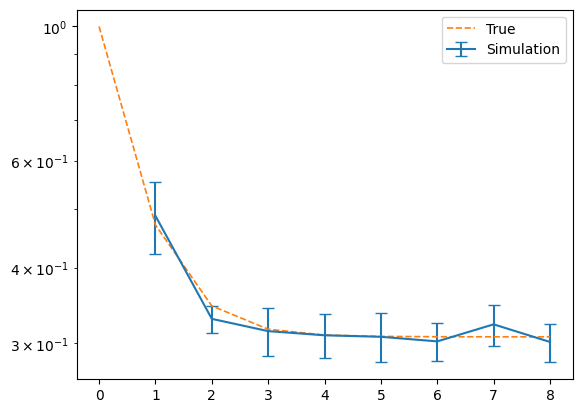

In [33]:
purities = np.load(f'data/experiment/purity/ideal/purity_Nb{n_bath}L{n_depth}.npy')
avg_purities = purities.mean(1)
std_purities = purities.std(1)

plt.errorbar(np.arange(1, 9), avg_purities, yerr=std_purities, label='Simulation', capsize=4)
plt.plot(np.arange(9), FP1evo(4, 4, np.arange(9)), linewidth=1.2, linestyle='--', label='True')
plt.legend()
plt.yscale('log')

## $2+2$ Qubits, Noise Simulation

In [35]:
backend = FakeKyiv()
estimator = EstimatorV2(mode=backend)

In [36]:
backend_name = 'kyiv'
n_batch = 10
n_depth = 5
n_bath = 2

purities = []
for n_step in range(1, 9):
    t0 = time.time()
    np.random.seed(12)
    n_total_param = (2 + n_bath) * (2 * n_depth * n_step)
    param_random = np.random.uniform(0, 4. * np.pi, (n_batch, n_total_param))

    # must transpile circuit for real/fake backend
    circuit = transpile(create_circuit(n_step, n_depth, n_bath), backend)

    # arragne observables based on transpiled circuit's layout
    observables = [[SparsePauliOp.from_sparse_list(
        [(q + p, [0, 1], 1.)], num_qubits=4).apply_layout(circuit.layout)] for p in pauli_op for q in pauli_op][1:]

    pub = (circuit, observables, param_random)
    job = estimator.run([pub])
    r_vals = job.result()[0].data.evs
    purity = (1. + (r_vals ** 2.).sum(0)) / 4.

    purities.append(purity)
    print(f'step {n_step}, time={time.time() - t0:.3f}')

purities = np.array(purities)


path = f'data/experiment/purity/{backend_name}Simu'
if not os.path.exists(path):
    os.mkdir(path)
np.save(os.path.join(path, f'purity_Nb{n_bath}L{n_depth}_{backend_name}Simu.npy'), purities)

step 1, time=15.827
step 2, time=14.368
step 3, time=15.791
step 4, time=17.038
step 5, time=18.425
step 6, time=19.547
step 7, time=21.706
step 8, time=24.803


Text(0, 0.5, '$F$')

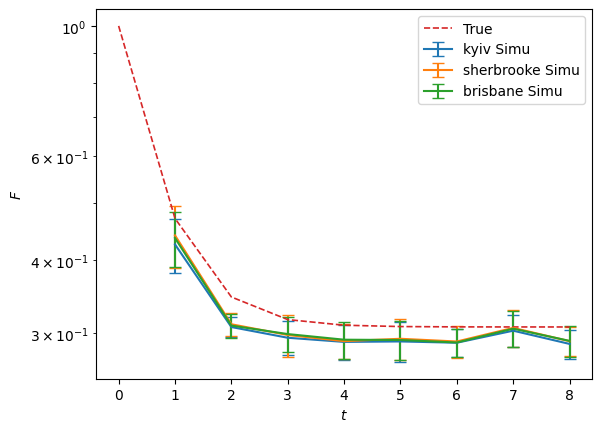

In [39]:
n_depth = 5
n_bat = 2

backend_list = ['kyiv', 'sherbrooke', 'brisbane']
purities = []
for backend_name in backend_list:
    path = f'data/experiment/purity/{backend_name}Simu'
    each = np.load(os.path.join(path, f'purity_Nb{n_bath}L{n_depth}_{backend_name}Simu.npy'))
    purities.append(each)

for i in range(3):
    plt.errorbar(np.arange(1, 9), np.mean(purities[i], axis=1), yerr=np.std(purities[i], axis=1), 
        label=f'{backend_list[i]} Simu', capsize=4)
plt.plot(np.arange(9), FP1evo(4, 4, np.arange(9)), linewidth=1.2, linestyle='--', label='True')
plt.legend()
plt.yscale('log')
plt.xlabel(r'$t$')
plt.ylabel(r'$F$')

# retrieve jobs

In [45]:
token = open('./IBMQ_token_usc.txt','r').read()
service = QiskitRuntimeService(
    channel='ibm_quantum',
    token=token
)

jobs = service.jobs(session_id='cxaz0q2rkac00089qt90')

In [ ]:
purities = []
for j in jobs:
    res = j.result()[0].data
    purity = (1. + (res.evs ** 2.).sum(0)) / 4.
    purities.append(purity)

purities = np.array(purities)
np.save('data/experiment/purity/sherbrooke/purity_Na2Nb2L4.npy', purities[::-1])

# condition state purity

In [3]:
def create_circuit_record(n_step, n_depth, n_bath, pauli_str):
    n_data = 2
    n_wires = n_data + n_bath
    n_param = 2 * n_depth * n_step
    n_register = n_data + n_bath * n_step

    # circuit parameter storages
    param_data = [ParameterVector(f'data_{i}', length=n_param) for i in range(n_data)]
    param_bath = [ParameterVector(
        'bath_' + str(b), length=n_param) for b in range(n_bath)]

    q = QuantumRegister(n_wires, 'q')
    c = ClassicalRegister(n_register, 'c')
    circuit = QuantumCircuit(q, c)

    for t in range(n_step):
        for d in range(n_depth):
            param_id = 2 * d + 2 * n_depth * t
            for i in range(n_data):
                circuit.ry(param_data[i][param_id], i)
                circuit.rz(param_data[i][param_id + 1], i)

            for b in range(n_bath):
                circuit.ry(param_bath[b][param_id], n_data + b)
                circuit.rz(param_bath[b][param_id + 1], n_data + b)

            for i in range(n_wires//2):
                circuit.cx(2*i, 2*i+1)

            for i in range((n_wires - 1)//2):
                circuit.cx(2*i+1, 2*i+2)

        register_id = n_data + t * n_bath
        circuit.measure(range(n_data, n_wires), range(
            register_id, register_id + n_bath))

        if t < n_step - 1:
            for b in range(n_bath):
                circuit.reset(n_data + b)
    circuit.barrier(range(n_data + n_bath))
    # measure the data qubit in given pauli basis
    for i in range(n_data):
        if pauli_str[i] == 'X':
            circuit.h(i)
        elif pauli_str[i] == 'Y':
            circuit.sdg(i)
            circuit.h(i)
    circuit.measure(range(n_data), range(n_data))

    return circuit

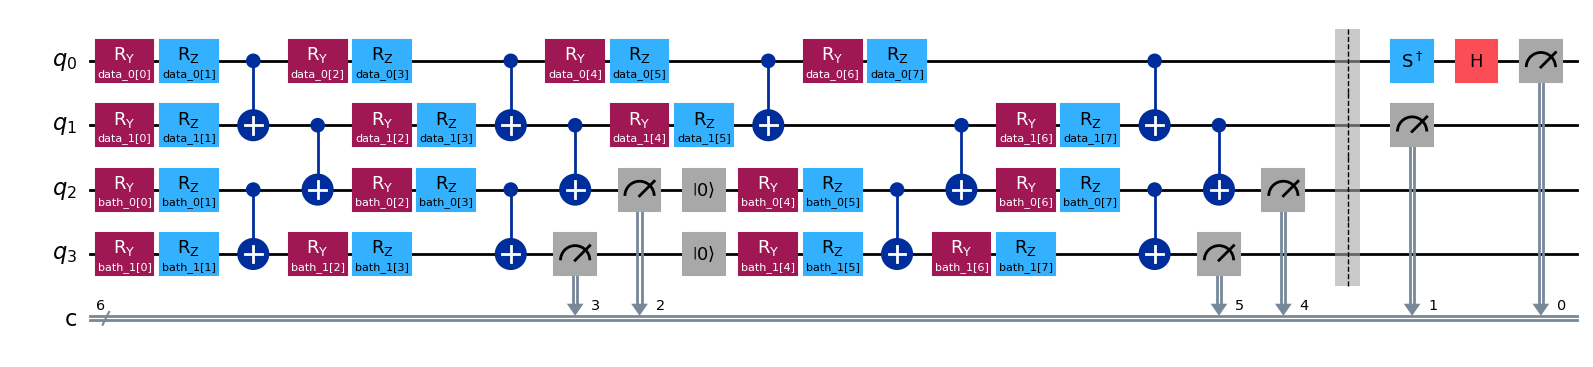

In [147]:
circuit = create_circuit_record(2, 2, 2, 'YZ')
circuit.draw('mpl')

In [2]:
pauli_op = ['X', 'Y', 'Z']
pauli_strs = [q + p for p in pauli_op for q in pauli_op]


['XX', 'YX', 'ZX', 'XY', 'YY', 'ZY', 'XZ', 'YZ', 'ZZ']

In [5]:
def get_pauliValue(bit_string_counts, pauli_str):
    n_data = 2
    # convert count dict to pd frame
    df = pd.DataFrame.from_dict(
        bit_string_counts, orient='index').reset_index()
    df.columns = ['bits', 'counts']

    # split data and ancilla
    df['bits'] = [x[::-1] for x in df['bits']]
    df['data_bits'] = df['bits'].str[:n_data]
    df['bath_bits'] = df['bits'].str[n_data:]

    # apply coefficient for different data_bits given pauli_str
    if not 'I' in pauli_str:
        # both pauli observable is non-trivial
        df['pauli_coeff'] = df['data_bits'].apply(lambda x: 1 if x in ['00', '11'] else -1)
    else:
        if pauli_str[0] == 'I':
            # if first pauli observable is trivial
            df['pauli_coeff'] = df['data_bits'].apply(lambda x: 1 if x in ['00', '10'] else -1)
        else:
            # if second pauli observable is trivial
            df['pauli_coeff'] = df['data_bits'].apply(lambda x: 1 if x in ['00', '01'] else -1)

    # find result with different bath_bits
    unique_bath_bits = df['bath_bits'].unique()
    pauli_expects = {}
    for i in range(len(unique_bath_bits)):
        A_bits = df[df['bath_bits'] == unique_bath_bits[i]]
        total_shots = sum(A_bits['counts'])
        res = (A_bits['counts'] * A_bits['pauli_coeff']).sum()
        pauli_expects[unique_bath_bits[i]] = res / total_shots
    
    return pauli_expects

In [31]:
def get_purity(counts_dict):
    paulis = ['I', 'X', 'Y', 'Z']
    obs = [p + q for p in paulis for q in paulis][1:]
    
    expects_dict = {}
    for P in obs:
        if P[0] == 'I':
            expects_dict[P] = get_pauliValue(counts_dict['Z'+P[1]], P)
        elif P[1] == 'I':
            expects_dict[P] = get_pauliValue(counts_dict[P[0]+'Z'], P)
        else:
            expects_dict[P] = get_pauliValue(counts_dict[P], P)
    # df = pd.DataFrame.from_dict(
    #     expects_dict, orient='index').reset_index()
    
    df = pd.DataFrame(expects_dict)
    df_no_nan = df.dropna()
    return np.sum(df_no_nan**2, axis=1)/4 + 0.25

In [73]:
# ideal simulation
for n_step, n_bath in product(range(1, 4), repeat=2):
    n_depth = 2 + n_bath
    
    np.random.seed(50)
    n_total_param = 2*(2 + n_bath) * n_depth * n_step
    param_random = np.random.uniform(0, 4. * np.pi, n_total_param)
    
    counts_dict = {}
    for x in pauli_strs:
        circuit = create_circuit_record(n_step, n_depth, n_bath, x)
        bound_circuit = circuit.assign_parameters(param_random)
        job = AerSimulator().run(bound_circuit, shots=2**(n_step*n_bath)*2**10)
        res = job.result().get_counts(bound_circuit)
        counts_dict[x] = res

    purities_id = get_purity(counts_dict)
    print(f'n_step={n_step}, n_bath={n_bath}: num_measure_result={len(purities_id)}, purity_mean={np.mean(purities_id)}, purity_std={np.std(purities_id)}')

n_step=1, n_bath=1: num_measure_result=2, purity_mean=0.9983896692446299, purity_std=0.019247356789548087
n_step=1, n_bath=2: num_measure_result=4, purity_mean=0.9984732191750818, purity_std=0.00786451830249582
n_step=1, n_bath=3: num_measure_result=8, purity_mean=0.9900818909876508, purity_std=0.022746094235800072
n_step=2, n_bath=1: num_measure_result=4, purity_mean=1.0015133395006686, purity_std=0.014249680040321991
n_step=2, n_bath=2: num_measure_result=16, purity_mean=1.0006216568011466, purity_std=0.028690712858634105
n_step=2, n_bath=3: num_measure_result=64, purity_mean=1.0071875463596065, purity_std=0.025852504671376793
n_step=3, n_bath=1: num_measure_result=8, purity_mean=1.0081016217758851, purity_std=0.04241461690204321
n_step=3, n_bath=2: num_measure_result=64, purity_mean=1.0063561293667609, purity_std=0.029017345336928423
n_step=3, n_bath=3: num_measure_result=512, purity_mean=1.005179490753675, purity_std=0.03098741323316316


In [74]:
token = open('IBMQ_token_usc.txt','r').read()
service = QiskitRuntimeService(
    channel='ibm_quantum',
    token=token
)

In [76]:
backend_name = 'brisbane'
backend = service.backend(f"ibm_{backend_name}")
backend_sim = AerSimulator.from_backend(backend)

In [83]:
# noisy simulation
for n_step, n_bath in product(range(1, 4), repeat=2):
    n_depth = 2 + n_bath
        
    np.random.seed(50)
    n_total_param = 2*(2 + n_bath) * n_depth * n_step
    param_random = np.random.uniform(0, 4. * np.pi, n_total_param)
    
    counts_dict = {}
    for x in pauli_strs:
        circuit = create_circuit_record(n_step, n_depth, n_bath, x)
        transpiled_circuit = transpile(circuit, backend)
        bound_circuit = transpiled_circuit.assign_parameters(param_random)
        
        job = backend_sim.run(bound_circuit, shots=2**(n_step*n_bath)*2**10)
        res = job.result().get_counts(bound_circuit)
        counts_dict[x] = res
    
    purities_noisy = get_purity(counts_dict)
    print(f'n_step={n_step}, n_bath={n_bath}: num_measure_result={len(purities_noisy)}, purity_mean={np.mean(purities_noisy)}, purity_std={np.std(purities_noisy)}')

n_step=1, n_bath=1: num_measure_result=2, purity_mean=0.8975425433803239, purity_std=0.006934108585373466
n_step=1, n_bath=2: num_measure_result=4, purity_mean=0.7569322638889036, purity_std=0.08508826845029391
n_step=1, n_bath=3: num_measure_result=8, purity_mean=0.7150507926494825, purity_std=0.0732131416031903
n_step=2, n_bath=1: num_measure_result=4, purity_mean=0.7992902326595113, purity_std=0.04230782639494662
n_step=2, n_bath=2: num_measure_result=16, purity_mean=0.6959336736596023, purity_std=0.06266236580956092
n_step=2, n_bath=3: num_measure_result=64, purity_mean=0.5809022196132876, purity_std=0.09718888939877728
n_step=3, n_bath=1: num_measure_result=8, purity_mean=0.7422494670485643, purity_std=0.08298201454437823
n_step=3, n_bath=2: num_measure_result=64, purity_mean=0.5937184459249851, purity_std=0.10279367629243616
n_step=3, n_bath=3: num_measure_result=512, purity_mean=0.5082181378500445, purity_std=0.09844673794997345


In [85]:
purity_noisy = np.array([[0.8975425433803239, 0.7569322638889036, 0.7150507926494825],
                         [0.7992902326595113, 0.6959336736596023, 0.5809022196132876],
                         [0.7422494670485643, 0.5937184459249851, 0.5082181378500445]])